<a href="https://colab.research.google.com/github/NanoPyro/prec_class/blob/main/Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade plotly

     |████████████████████████████████| 13.2MB 209kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore") # Remove redundant error messages

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/train.csv')
test = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/test.csv')

# Getting to know the data

In [5]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [6]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
train.tail()

,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [8]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [9]:
train.info() # There are some null values in text, selected_text columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [10]:
train.dropna(inplace=True) # Drop those null values

In [11]:
test.info() # No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


## EDA

In [12]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,07324d05c0,"Sydney - Toyota - Landcruiser - 1996 - $10,000...",good,neutral
freq,1,1,199,11117


### Visulization

In [13]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Reds') # Paint the column for readability

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


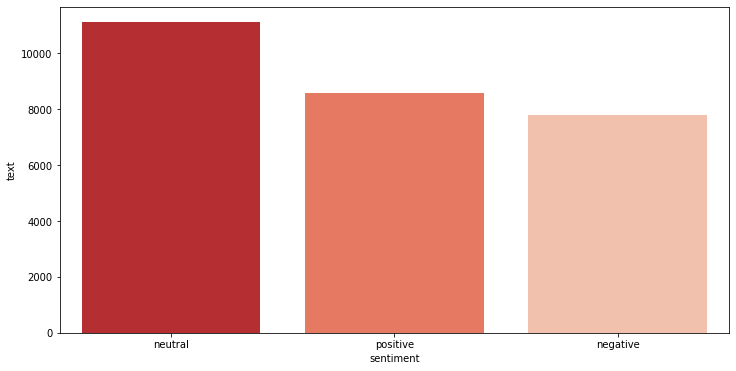

In [14]:
plt.figure(figsize=(12,6))
sns.barplot(x='sentiment', y='text', data=temp, palette='Reds_r') # Visualiztion from table to bar plot

In [15]:
# Drawing a funnel chart
fig = go.Figure(go.Funnelarea(text = temp.sentiment, values = temp.text, title = {'position': 'top center', 'text': 'Funnel chart of sentiment distribution'}))
# Using plotly because matplotlib doesn't support funnel chart directly
fig.show()

Neutral sentimented tweets are the most coomon tweets.  
Thus if we can classify those neutral tweets first, the rest should be easy.

In [16]:
def jaccard(s1, s2): # Defining Jaccard index function
  x = set(s1.lower().split())
  y = set(s2.lower().split())
  z = x.intersection(y)
  return float( len(z) / (len(x) + len(y) - len(z)) ) # Return the Jaccard index

What's Jaccard index?  
https://en.wikipedia.org/wiki/Jaccard_index  
To simpy put, it's used to measure how two sets are alike.

In [17]:
results_jaccard = []

for row in train.itertuples():
  sentence1 = row.text
  sentence2 = row.selected_text

  jacc = jaccard(sentence1, sentence2)
  results_jaccard.append([sentence1, sentence2, jacc])

In [18]:
jaccard_df = pd.DataFrame(results_jaccard, columns=['text', 'selected_text', 'jacc'])
train = train.merge(jaccard_df, how='outer')

In [19]:
train['num_words_st'] = train['selected_text'].apply(lambda x: len(str(x).split())) # Number of words in the selected text
train['num_words_text'] = train['text'].apply(lambda x: len(str(x).split())) # Number of words in the main text
train['words_diff'] = train['num_words_text'] - train['num_words_st'] # Difference in the number of words between text and selected text

In [20]:
train.head()

,textID,text,selected_text,sentiment,jacc,num_words_st,num_words_text,words_diff
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


This is what the data frame looks like after what we've done.

In [21]:
temp_df = train.groupby('sentiment').mean()
temp_df

,jacc,num_words_st,num_words_text,words_diff
sentiment,,,,
negative,0.338613,3.957975,13.473204,9.515229
neutral,0.976445,12.069533,12.343888,0.274355
positive,0.314372,3.519343,13.109881,9.590538


As we can see, the neutral tweets' average jaccard score is 0.976.  
And that is way above those of negative and positive tweets.  
Looks like jaccard scores tweets could be classified as neutral tweets.

In [22]:
hist_data = [train['num_words_st'], train['num_words_text']]

group_labels = ['selected_text', 'text']

fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
fig.update_layout(title_text='Distribution of Number of Words')
fig.update_layout(autosize=False, width=900, height=700, paper_bgcolor='LightSteelBlue')
fig.show()

Apparently, most of the tweets are short.  
Considering the fact that there is words limit on Twitter, this seems reasonable. 

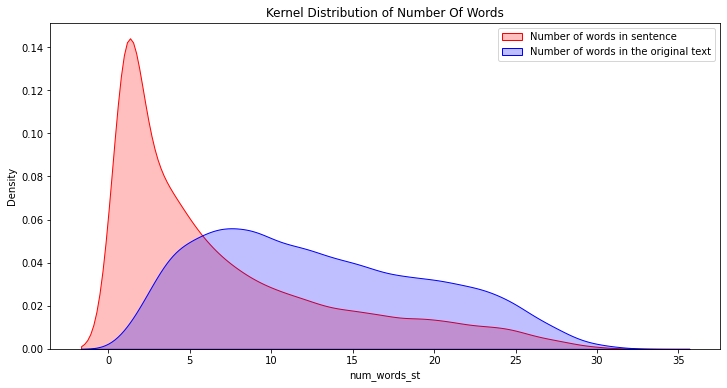

In [23]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['num_words_st'], shade=True, color="r").set_title('Kernel Distribution of Number Of Words')
p1=sns.kdeplot(train['num_words_text'], shade=True, color="b")
plt.legend(labels=['Number of words in sentence', 'Number of words in the original text'])

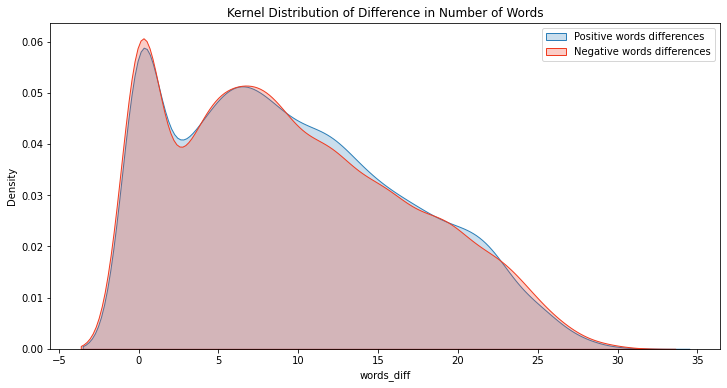

In [24]:
plt.figure(figsize=(12,6))
arg = [train[train['sentiment']=='positive']['words_diff'], train[train['sentiment']=='negative']['words_diff']]
p1 = sns.kdeplot(train[train['sentiment']=='positive']['words_diff'],
                 shade=True, color='#2c7fb8').set_title('Kernel Distribution of Difference in Number of Words')
p2 = sns.kdeplot(train[train['sentiment']=='negative']['words_diff'],
                 shade=True, color='#f03b20')
plt.legend(labels=['Positive words differences', 'Negative words differences'])

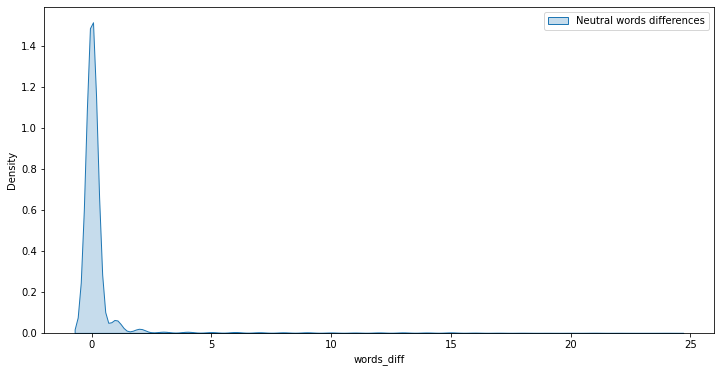

In [25]:
plt.figure(figsize=(12,6))
sns.kdeplot(train[train['sentiment']=='neutral']['words_diff'], shade=True)
plt.legend(labels=['Neutral words differences'])

As we can see, the majority of the differences in words between text and selected_text is 0 (when the tweet has neutral sentiment).  
In fact, this makes sense in that if the tweet is of neutral sentiment, we can't pick a specific word(s) to represent the tweet's feeling.

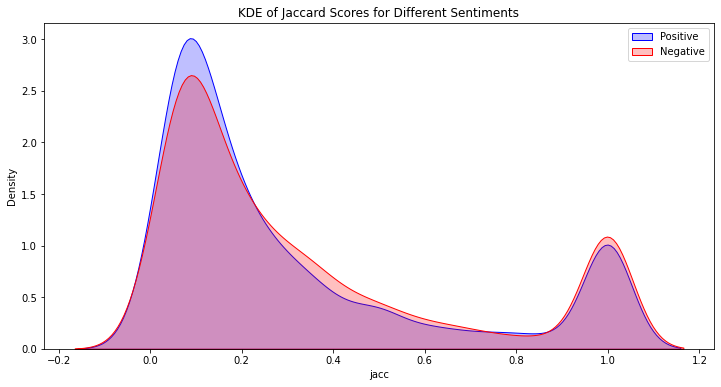

In [26]:
plt.figure(figsize=(12,6))
p1 = sns.kdeplot(train[train['sentiment']=='positive']['jacc'], shade=True, color='b').set_title('KDE of Jaccard Scores for Different Sentiments')
p2 = sns.kdeplot(train[train['sentiment']=='negative']['jacc'], shade=True, color='r')
plt.legend(labels=['Positive', 'Negative'])

There are two points where the densities are high.  
Jaccard scores around 0.1, and 1.

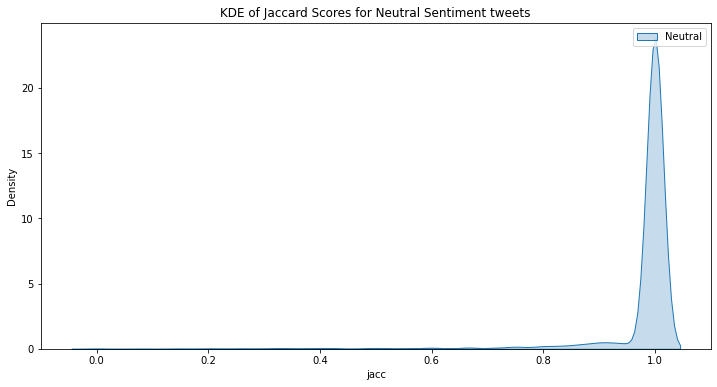

In [27]:
plt.figure(figsize=(12,6))
sns.kdeplot(train[train['sentiment']=='neutral']['jacc'], shade=True).set_title('KDE of Jaccard Scores for Neutral Sentiment tweets')
plt.legend(labels=['Neutral'])

I drew the kde graph for neutral tweets separately because of relatively high desnity.  
And as implied by the average jaccard score, there is only one point with high density.

Text(0.5, 1.0, 'Distribution of Jaccard Scores For Neutral Sentiment Tweets')

<Figure size 864x432 with 0 Axes>

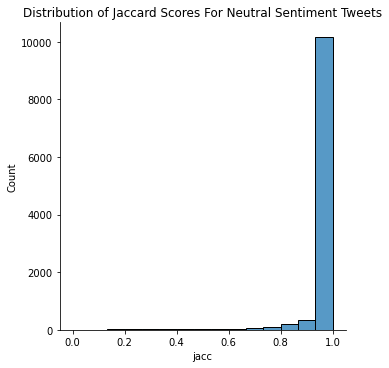

In [28]:
plt.figure(figsize=(12,6))
sns.displot(train[train['sentiment']=='neutral']['jacc'], kde=False)
plt.title('Distribution of Jaccard Scores For Neutral Sentiment Tweets')

For positive and negative tweets, there were two points with high density.  
And for neutral tweets, there is only one acute point in this graph.

In [29]:
temp_df = train[train['num_words_text'] <= 2]
temp_df.groupby('sentiment').mean()['jacc']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jacc, dtype: float64

Contrary to what we've seen earlier if we limit the number of words in the original text less than or equal to 2, the average jaccard scores of the tweets are higher.  
This might affect our model's performance.

In [30]:
def to_plain(s):
  s = str(s).lower()
  s = re.sub('\[.*?\[', '', s)
  s = re.sub('https?://\S+|www\.\S+', '', s)
  s = re.sub('<.*?>+', '', s)
  s = re.sub('[%s]' % re.escape(string.punctuation), '', s)
  s = re.sub('\n', '', s)
  s = re.sub('\w*\d\w*', '', s)
  return s

Now we are about to clean the texts with hyperlinks, parantheses, or other unnecessary components.

In [31]:
train['text'] = train['text'].apply(lambda s: to_plain(s))
train['selected_text'] = train['selected_text'].apply(lambda s: to_plain(s))
train.head()

,textID,text,selected_text,sentiment,jacc,num_words_st,num_words_text,words_diff
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


Now that we've cleaned up our texts, let's look into what is the most common word in the tweets.

In [32]:
dup = train['selected_text'].apply(lambda s: str(s).split())
dup

0                [id, have, responded, if, i, were, going]
1                                              [sooo, sad]
2                                           [bullying, me]
3                                       [leave, me, alone]
4                                               [sons, of]
                               ...                        
27475                                            [d, lost]
27476                                        [dont, force]
27477                      [yay, good, for, both, of, you]
27478                            [but, it, was, worth, it]
27479    [all, this, flirting, going, on, the, atg, smi...
Name: selected_text, Length: 27480, dtype: object

dup is a pandas series, and each of component consists of a list.  
Although we cleaned up the texts, there are still remaining stopwords.  
Let's get rid of them.

In [33]:
def rmv_stopword(x):
  return [y for y in x if y not in stopwords.words('english')]

In [34]:
dup = dup.apply(lambda x: rmv_stopword(x))
cnt = Counter([wrd for lst in dup for wrd in lst])
common = pd.DataFrame(cnt.most_common(20))
common

,0,1
0,im,1678
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,614


The first row is not needed.

In [35]:
common = common.iloc[1:, :]
common.columns = ['word', 'count']
common.style.background_gradient(cmap='Reds')

,word,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,614
10,work,612


In [36]:
fig = px.treemap(common, path=['word'], values='count', title='Most Common Words')
fig.show()

This figure was generated using plotly.  
So it is not visible on Github. :(

In [37]:
temp_lst = train['text'].apply(lambda x: str(x).split())
temp_lst = temp_lst.apply(lambda x: rmv_stopword(x))

cnt2 = Counter([wrd for lst in temp_lst for wrd in lst])
common2 = pd.DataFrame(cnt2.most_common(25))
common2

,0,1
0,im,3024
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096


Once again, the first row is not needed.

In [38]:
common2 = common2.iloc[1:, :]
common2.columns = ['word', 'count']
common2.style.background_gradient(cmap='Reds')

,word,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


The result is very similar to that of selected_text column.

But it looks like the most common words are only related to positive tweets.  
What about negative and neutral tweets?  
Let's find out. 

In [39]:
train['sel_txt_no_stopword'] = dup
train['txt_no_stopword'] = temp_lst

pos = train[train['sentiment'] == 'positive']
neg = train[train['sentiment'] == 'negative']
neu = train[train['sentiment'] == 'neutral']

In [40]:
cnt = Counter([txt for lst in pos['sel_txt_no_stopword'] for txt in lst])
pos_df = pd.DataFrame(cnt.most_common(20))
pos_df.columns = ['words', 'count']
pos_df.style.background_gradient(cmap='Reds')

,words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [41]:
cnt = Counter([txt for lst in neg['sel_txt_no_stopword'] for txt in lst])
neg_df = pd.DataFrame(cnt.most_common(20))
neg_df.columns = ['words', 'count']
neg_df

,words,count
0,im,452
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162


The first row is not needed.

In [42]:
neg_df = neg_df.iloc[1:, :]
neg_df.style.background_gradient(cmap='Reds')

,words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [43]:
cnt = Counter([txt for lst in neu['sel_txt_no_stopword'] for txt in lst])
neu_df = pd.DataFrame(cnt.most_common(20))
neu_df.columns = ['words', 'count']
neu_df

,words,count
0,im,1041
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,442
9,today,427


The first row is not needed.

In [44]:
neu_df = neu_df.iloc[1:, :]
neu_df.style.background_gradient(cmap='Reds')

,words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,442
9,today,427
10,lol,427


Looks like we've got fair results.  
Highest frequent words seem to fit in each category.

#Modeling

We are going to build models as NER (Named Entity Recognition)

In [65]:
train_df = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/test.csv')
ss_df = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/sample_submission.csv')

In [46]:
train_df['num_text'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df = train_df[train_df['num_text'] >= 3]

We take tweets with 3 words or more.

In [53]:
def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")
        print("Created blank 'en' model")
  
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe("ner")
    
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, drop=0.5, losses=losses)
            print("Losses", losses)
    store_model(output_dir, nlp, 'st_ner')

Dropout rate = 0.5, which means the model randomly drop individual features.  
And this helps overfitting occur less likely.

In [49]:
def get_data(sent):
  train_data = []
  for row in train_df.itertuples():
    if row.sentiment == sent:
      selec_txt = row.selected_text
      txt = row.text
      start = txt.find(selec_txt)
      end = start + len(selec_txt)
      train_data.append( (txt, {"entities": [[start, end, 'selected_text']]}) )
  return train_data

Fetches train data file.

In [50]:
def store_model(path, nlp, model):
  path = f'../{path}'
  if path is not None:
    if not os.path.exists(path):
      os.makedirs(path)
    nlp.meta["name"] = model
    nlp.to_disk(path)
    print("Stored to: {0}".format(path))

Stores our model.

In [54]:
train_data = get_data('positive')
train(train_data, '/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/models/pos', 3)


  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model



 33%|███▎      | 1/3 [06:00<12:01, 360.92s/it]

Losses {'ner': 33604.81712694322}



 67%|██████▋   | 2/3 [11:59<06:00, 360.26s/it]

Losses {'ner': 31137.488850546215}



100%|██████████| 3/3 [17:57<00:00, 359.28s/it]

Losses {'ner': 29516.521621259297}


Stored to: ..//content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/models/pos


In [55]:
train_data = get_data('negative')
train(train_data, '/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/models/neg', 3)


  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model



 33%|███▎      | 1/3 [05:29<10:58, 329.47s/it]

Losses {'ner': 31545.421740298567}



 67%|██████▋   | 2/3 [10:58<05:29, 329.20s/it]

Losses {'ner': 28225.275054574136}



100%|██████████| 3/3 [16:27<00:00, 329.13s/it]

Losses {'ner': 26936.120962207242}
Stored to: ..//content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/models/neg


Looks like Colab is much.. slower.. than.. Kaggle.. notebook..

In [58]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = len(ent.text) + start
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selec_txt = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selec_txt

In [76]:
selected_texts = []
MODELS_BASE_PATH = '/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/input/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models from: {0}".format(MODELS_BASE_PATH))
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for row in test_df.itertuples():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
test_df['selected_text'] = selected_texts

Loading Models  from  /content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/input/models/


In [77]:
test_df.head()

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,exciting
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,Recession
3,01082688c6,happy bday!,positive,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,I like it!!


In [74]:
ss_df.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [78]:
ss_df['selected_text'] = test_df['selected_text']
ss_df.to_csv('submission.csv', index=False)
ss_df.head(20)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,Recession
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!
5,726e501993,visitors!
6,261932614e,HATES
7,afa11da83f,blocked
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...


Final submission file is completed!